## 1º Bloco — Event Preprocessing

In [51]:
from pathlib import Path
from skimage.util import view_as_blocks
from aermanager.aerparser import load_events_from_file
from aermanager.parsers import parse_dvs_ibm
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import pandas as pd
from matplotlib import animation
#from IPython.display import display, HTML

import sparse  # pydata/sparse

In [52]:
# Dataset paths + hiperparameters

cwd = Path.cwd()
PROJECT_ROOT = None
for p in [cwd] + list(cwd.parents):
    if p.name == "Tese":
        PROJECT_ROOT = p
        break

if PROJECT_ROOT is None:
    raise RuntimeError(f"Could not find project root folder 'Tese' from CWD={cwd}")

# DVS128 dataset root
ROOT = PROJECT_ROOT / "datasets" / "DVS128"
DATA = ROOT / "data"

# Trial selection
TRIAL_STEM = "user01_fluorescent_led"
AEDAT_PATH  = DATA / f"{TRIAL_STEM}.aedat"
LABELS_PATH = DATA / f"{TRIAL_STEM}_labels.csv"

# Sanity check
print("PROJECT_ROOT:", PROJECT_ROOT)
print("AEDAT exists:", AEDAT_PATH.exists(), AEDAT_PATH)
print("LABELS exists:", LABELS_PATH.exists(), LABELS_PATH)

# =========================================================
# DVS128 / xR-EvT preprocessing parameters
# =========================================================

# Sensor resolution
H, W = 128, 128

# Offline sparse-frame duration (from clean_dataset_frames_12000)
SPARSE_FRAME_LEN_US = 12000  # 12 ms

# Hiperparameters 
CHUNK_LEN_MS = 48   # Duration of each model time window Δt (ms)
BINS = 4            # Number of temporal bins within each Δt window
patch_size = 8      # Spatial patch size (P×P pixels)
m = 0.10            # Minimum fraction of active pixels required per patch
n_min = 5           # Minimum number of active patches per Δt window

PROJECT_ROOT: /Users/pedrofs/ISCTE-Projetos/Mestrado/Tese
AEDAT exists: True /Users/pedrofs/ISCTE-Projetos/Mestrado/Tese/datasets/DVS128/data/user01_fluorescent_led.aedat
LABELS exists: True /Users/pedrofs/ISCTE-Projetos/Mestrado/Tese/datasets/DVS128/data/user01_fluorescent_led_labels.csv


In [ ]:
def read_labels_csv(path: Path):
    rows = []
    with path.open("r", newline="") as f:
        reader = csv.DictReader(f)
        for r in reader:
            rows.append({
                "class": int(r["class"]),
                "start": int(r["startTime_usec"]),
                "end": int(r["endTime_usec"]),
            })
    return rows

labels = read_labels_csv(LABELS_PATH)
len(labels), labels[0]

gesture_idx = 0  # Alteravel
gesture = labels[gesture_idx]

t0, t1 = gesture["start"], gesture["end"]


In [54]:
def read_aedat31_polarity_events(path: Path) -> np.ndarray:
    """
    Parse AEDAT 3.1 polarity events into an int64 array [N,4] in (x,y,t,p).
    Handles the ASCII header (#!... lines) before the binary event packets.
    """
    data_bytes = path.read_bytes()

    # --- Skip ASCII header if present ---
    offset = 0
    if data_bytes.startswith(b"#!AER-DAT"):
        end_marker = b"#!END-HEADER"
        end = data_bytes.find(end_marker)
        if end == -1:
            raise RuntimeError("AEDAT text header detected but '#!END-HEADER' not found.")
        # Move offset to the end of that line (consume trailing newline if any)
        offset = end + len(end_marker)
        # consume \r\n or \n
        if offset < len(data_bytes) and data_bytes[offset:offset+2] == b"\r\n":
            offset += 2
        elif offset < len(data_bytes) and data_bytes[offset:offset+1] == b"\n":
            offset += 1

    events_list = []

    # --- Binary packets: repeated [28-byte header][eventNumber * eventSize bytes] ---
    while offset + 28 <= len(data_bytes):
        eventType   = int.from_bytes(data_bytes[offset:offset+2], "little")
        eventSource = int.from_bytes(data_bytes[offset+2:offset+4], "little")
        eventSize   = int.from_bytes(data_bytes[offset+4:offset+8], "little")
        eventTSOff  = int.from_bytes(data_bytes[offset+8:offset+12], "little")
        eventTSOv   = int.from_bytes(data_bytes[offset+12:offset+16], "little")
        eventCap    = int.from_bytes(data_bytes[offset+16:offset+20], "little")
        eventNum    = int.from_bytes(data_bytes[offset+20:offset+24], "little")
        eventValid  = int.from_bytes(data_bytes[offset+24:offset+28], "little")
        offset += 28

        if eventNum == 0 or eventSize == 0:
            continue

        block_bytes = eventNum * eventSize
        if offset + block_bytes > len(data_bytes):
            break

        # For DVS128 polarity events here: eventSize is typically 8 bytes:
        # [uint32 data][uint32 timestamp]
        if eventSize != 8:
            offset += block_bytes
            continue

        raw = np.frombuffer(data_bytes, dtype=np.uint32, count=(block_bytes // 4), offset=offset)
        offset += block_bytes

        if raw.size < 2:
            continue

        raw = raw.reshape(-1, 2)
        data_word = raw[:, 0]
        ts = raw[:, 1]

        x = (data_word >> 17) & 0x1FFF
        y = (data_word >> 2)  & 0x1FFF
        p = (data_word >> 1)  & 0x1

        m = (x < W) & (y < H)
        x, y, ts, p = x[m], y[m], ts[m], p[m]

        ev = np.stack([x, y, ts, p], axis=1).astype(np.int64)
        events_list.append(ev)

    if not events_list:
        raise RuntimeError(f"No events parsed from {path} (check AEDAT version / parser).")

    events = np.concatenate(events_list, axis=0)
    events = events[np.argsort(events[:, 2])]
    return events

In [55]:
# Load all events from the AEDAT file (entire trial)
events_all = read_aedat31_polarity_events(AEDAT_PATH)

# Basic info
num_events = events_all.shape[0]
t_start = events_all[:, 2].min()
t_end   = events_all[:, 2].max()
duration_s = (t_end - t_start) / 1e6

# Show first events as a table
df_preview = pd.DataFrame(
    events_all[:5],
    columns=["x", "y", "t (µs)", "p"]
)

print(f"Total events: {num_events}")
display(df_preview)

# Time range summary
print(
    f"\nAll Gestures: "
    f"t ∈ [{t_start}, {t_end}] µs "
    f"(duration = {duration_s:.2f} s)"
)

Total events: 8103978


,x,y,t (µs),p
0,46,79,72406439,1
1,49,96,72406447,1
2,45,69,72406503,1
3,78,97,72406506,0
4,88,79,72406551,0



All Gestures: t ∈ [72406439, 192326718] µs (duration = 119.92 s)


## 1º Bloco - Event stream (gesture)

We start from a single gesture represented as a continuous stream of DVS events `{x, y, t, p}`, already temporally segmented using the dataset annotations.

In [74]:
# Slice events for the selected gesture
def slice_events_by_time(events_xypt, t0, t1):
    t = events_xypt[:, 2]
    mask = (t >= t0) & (t < t1)
    return events_xypt[mask]

events_g = slice_events_by_time(events_all, t0, t1)

# Basic info
num_events_g = events_g.shape[0]
t_start_g = events_g[:, 2].min()
t_end_g   = events_g[:, 2].max()
duration_g_s = (t_end_g - t_start_g) / 1e6

# Show first events of the gesture as a table
df_preview_g = pd.DataFrame(
    events_g[:5],
    columns=["x", "y", "t (µs)", "p"]
)

print(f"Gesture {gesture_idx} — total events: {num_events_g}")
display(df_preview_g)

# Time range summary
print(
    f"\nGesture {gesture_idx}: "
    f"t ∈ [{t_start_g}, {t_end_g}] µs "
    f"(duration = {duration_g_s:.2f} s)"
)

Gesture 0 — total events: 248503


,x,y,t (µs),p
0,46,79,72406439,1
1,49,96,72406447,1
2,45,69,72406503,1
3,78,97,72406506,0
4,88,79,72406551,0



Gesture 0: t ∈ [72406439, 77491037] µs (duration = 5.08 s)


In [57]:
sf_dense = sf.todense()              # (T_sf, H, W, 2)
sf_vis = sf_dense.sum(axis=-1)       # sum ON/OFF → (T_sf, H, W)

fig, ax = plt.subplots()
im = ax.imshow(sf_vis[0], cmap="viridis")
ax.axis("off")

def update(i):
    im.set_data(sf_vis[i])
    ax.set_title(f"t = {i*12} ms")
    return [im]

ani = animation.FuncAnimation(
    fig, update, frames=len(sf_vis), interval=30
)

plt.close(fig)
ani

#display(HTML(ani.to_jshtml()))

### Sparse Frames (12 ms)

This image shows the accumulated events within a single 12 ms time window.

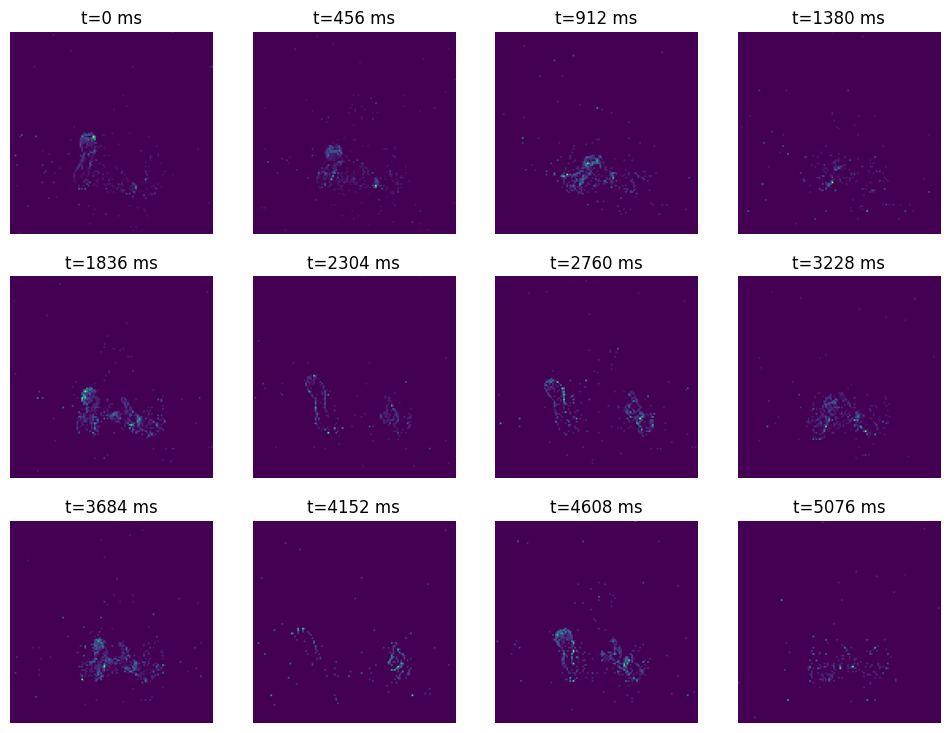

In [58]:
frames = sf_vis  # (T, H, W)
idxs = np.linspace(0, len(frames)-1, 12).astype(int)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for ax, i in zip(axes.ravel(), idxs):
    ax.imshow(frames[i], cmap="viridis")
    ax.set_title(f"t={i*12} ms")
    ax.axis("off")
plt.show()

In [59]:
def events_to_sparse_frames_12ms(
    events_xypt: np.ndarray,
    H: int,
    W: int,
    frame_len_us: int = 12000,
) -> sparse.COO:
    """
    Convert events (x,y,t,p) into stacked sparse frames:
      output shape: (T_sf, H, W, 2)
    Values are event counts per pixel/polarity, clipped to [0,255] and stored as uint8.
    """
    if events_xypt.size == 0:
        return sparse.COO(
            coords=np.zeros((4, 0), dtype=np.int64),
            data=np.zeros((0,), dtype=np.uint8),
            shape=(0, H, W, 2),
        )

    x = events_xypt[:, 0].astype(np.int64)
    y = events_xypt[:, 1].astype(np.int64)
    t = events_xypt[:, 2].astype(np.int64)
    p = events_xypt[:, 3].astype(np.int64)

    t_start = int(t.min())
    t_end   = int(t.max()) + 1
    T_sf = int(np.ceil((t_end - t_start) / frame_len_us))

    fidx = (t - t_start) // frame_len_us
    fidx = np.clip(fidx, 0, T_sf - 1)

    # Build 4D coords: (frame, y, x, polarity)
    coords = np.stack([fidx, y, x, p], axis=1)  # (N, 4)

    # Aggregate duplicates to get counts per unique coordinate
    uniq, counts = np.unique(coords, axis=0, return_counts=True)

    # Clip counts and cast to uint8 as in the repo preprocessing
    counts = np.clip(counts, 0, 255).astype(np.uint8)

    # sparse.COO expects coords shape (ndim, nnz)
    coo_coords = uniq.T.astype(np.int64)  # (4, nnz)
    coo = sparse.COO(coords=coo_coords, data=counts, shape=(T_sf, H, W, 2))
    return coo

In [60]:
sf = events_to_sparse_frames_12ms(
    events_g,
    H=H,
    W=W,
    frame_len_us=SPARSE_FRAME_LEN_US
)

# sf is sparse.COO with shape (T_sf, H, W, 2)
print(sf.shape)

(424, 128, 128, 2)


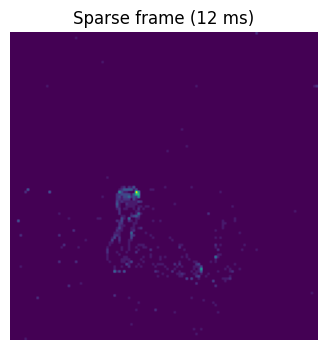

In [61]:
plt.figure(figsize=(4,4))
plt.imshow(sf_vis[0], cmap="viridis")
plt.title("Sparse frame (12 ms)")
plt.axis("off")
plt.show()

## Bloco 1.3. Δt windowing (model-level temporal windows)

Sparse frames are grouped into disjoint model-level temporal windows Δt, defined by `chunk_len_ms`, following the original xR-EvT backward traversal strategy.

In [62]:
chunk_len_us = CHUNK_LEN_MS * 1000
chunk_size = chunk_len_us // SPARSE_FRAME_LEN_US

T_sf = sf.shape[0]
sf_num = T_sf

dt_chunks = []

while sf_num > 0:
    start = sf_num - chunk_size
    if start < 0:
        break

    # backward, disjoint chunk
    current_chunk = sf[start:sf_num].todense()  # (chunk_size, H, W, 2)
    dt_chunks.append(current_chunk)
    sf_num = start

len(dt_chunks), dt_chunks[0].shape

(106, (4, 128, 128, 2))

### First Δt window (48 ms)

This visualization shows the aggregation of sparse frames composing
the first model-level temporal window (Δt = 48 ms).

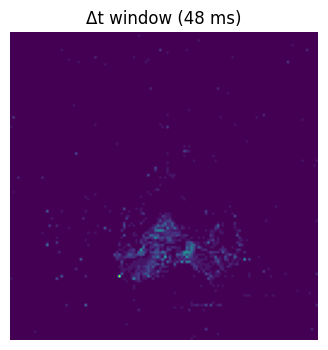

In [63]:
first_chunk = dt_chunks[0]           # (4, H, W, 2)
chunk_vis = first_chunk.sum(axis=(0, -1))  # sum time + polarity

plt.figure(figsize=(4,4))
plt.imshow(chunk_vis, cmap="viridis")
plt.title("Δt window (48 ms)")
plt.axis("off")
plt.show()

### Bloco 1.4. Temporal binning (B)

Each Δt window is subdivided into B temporal bins by summing consecutive sparse frames, preserving intra-window temporal structure.

In [64]:
def temporal_binning(chunk, B):
    """
    chunk: (T, H, W, C)
    returns: (H, W, C, B)
    """
    T = chunk.shape[0]
    idxs = np.array_split(np.arange(T), B)
    bins = [chunk[i].sum(axis=0) for i in idxs]
    return np.stack(bins, axis=-1)  # (H, W, C, B)

binned_chunks = [temporal_binning(chunk, BINS) for chunk in dt_chunks]
binned_chunks[0].shape

(128, 128, 2, 4)

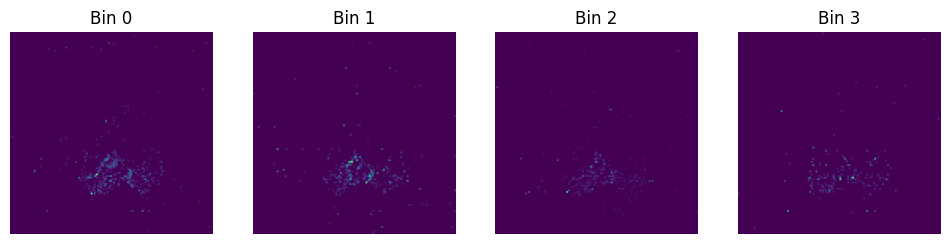

In [65]:
binned = binned_chunks[0]  # (H, W, C, B)

fig, axes = plt.subplots(1, BINS, figsize=(12,3))
for b in range(BINS):
    bin_vis = binned[..., b].sum(axis=-1)  # sum polarities
    axes[b].imshow(bin_vis, cmap="viridis")
    axes[b].set_title(f"Bin {b}")
    axes[b].axis("off")

plt.show()

## 2º Bloco - Event-Frame Builder:

Temporal bins and polarity channels are concatenated to form a 4D Event-Frame representation of shape `(H × W × B·C)`. In C = 2 channels.

In [66]:
event_frames = [
    bc.reshape(H, W, bc.shape[2] * bc.shape[3])  # (H, W, B*C)
    for bc in binned_chunks
]

event_frames[0].shape

(128, 128, 8)

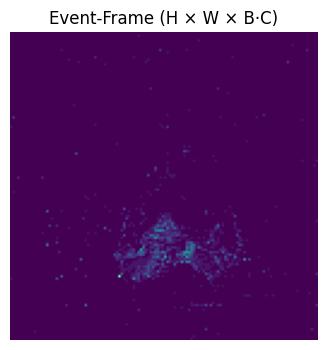

In [67]:
event_frame = event_frames[0]        # (H, W, B*C)
event_frame_vis = event_frame.sum(axis=-1)

plt.figure(figsize=(4,4))
plt.imshow(event_frame_vis, cmap="viridis")
plt.title("Event-Frame (H × W × B·C)")
plt.axis("off")
plt.show()

## 3º Bloco - Activated Patch Extraction: (PxP)

Each Event-Frame is spatially partitioned into non-overlapping P×P patches, forming a structured patch grid.

In [68]:
def extract_patch_grid(event_frame, P):
    # (H, W, B*C) -> (H/P, W/P, P, P, B*C)
    return view_as_blocks(event_frame, (P, P, event_frame.shape[2]))

patch_grids = [extract_patch_grid(ef, patch_size) for ef in event_frames]
patch_grids[0].shape

(16, 16, 1, 8, 8, 8)

## Bloco 3.1. Patch activation

Patches are marked as active if they contain a minimum number of pixels with non-zero event activity, following the xR-EvT activation criterion.

In [69]:
def activate_patches_percentage(patch_grid, P, m):
    """
    patch_grid: (H/P, W/P, P, P, B*C)
    m: fraction of active pixels required (0–1)
    returns:
        activation mask (H/P, W/P)
    """
    # Pixel is active if it has any event in any channel
    pixel_active = patch_grid.sum(axis=-1) != 0  # (H/P, W/P, P, P)

    active_pixel_count = pixel_active.sum(axis=(-1, -2))  # (H/P, W/P)

    min_pixels = int(np.ceil(m * P * P))

    return active_pixel_count >= min_pixels


activation_masks = [
    activate_patches_percentage(pg, P=patch_size, m=m)
    for pg in patch_grids
]

valid_windows = []

for mask in activation_masks:
    if mask.sum() >= n_min:
        valid_windows.append(True)
    else:
        valid_windows.append(False)

print(f"Valid Δt windows: {sum(valid_windows)} / {len(valid_windows)}")


Valid Δt windows: 106 / 106


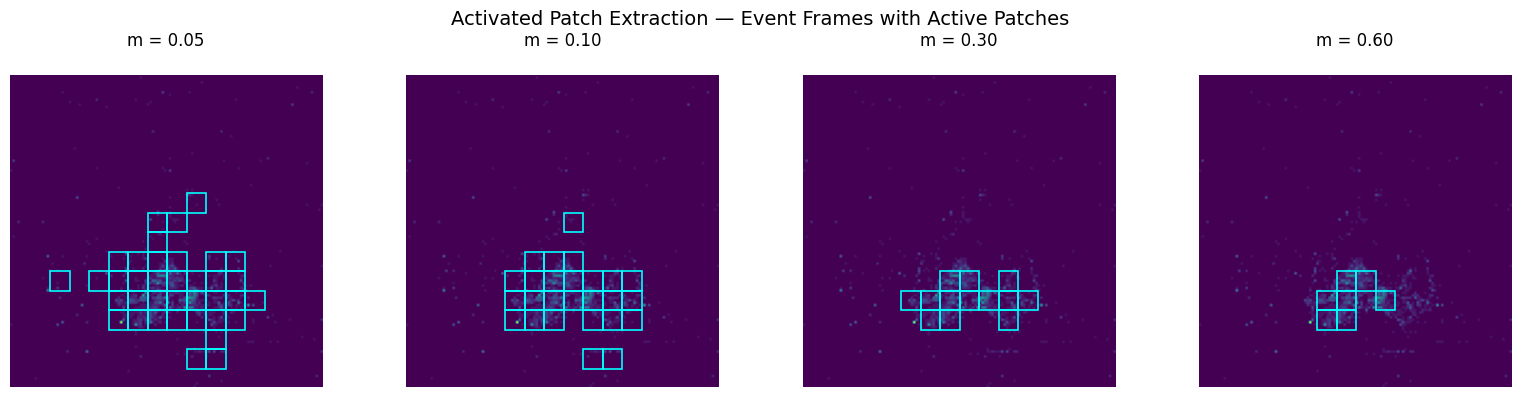

In [70]:
# Values of m to compare
m_values = [0.05, 0.10, 0.30, 0.60]

P = patch_size
pg = patch_grids[0]  # use the first Δt window

fig, axes = plt.subplots(1, len(m_values), figsize=(16, 4))

for ax, m_val in zip(axes, m_values):
    # Compute activation mask
    activation = activate_patches_percentage(pg, P=P, m=m_val)

    min_pixels = int(np.ceil(m_val * P * P))
    n_active = activation.sum()

    # Show base Event-Frame
    ax.imshow(event_frame_vis, cmap="viridis")

    # Overlay active patches
    for i in range(activation.shape[0]):
        for j in range(activation.shape[1]):
            if activation[i, j]:
                rect = plt.Rectangle(
                    (j * P, i * P),
                    P, P,
                    edgecolor="cyan",
                    facecolor="none",
                    linewidth=1.2
                )
                ax.add_patch(rect)

    ax.set_title(f"m = {m_val:.2f}\n")
    ax.axis("off")
    
plt.suptitle(
    "Activated Patch Extraction — Event Frames with Active Patches",
    fontsize=14
)
plt.tight_layout()
plt.show()

In [71]:
for m_test in [0.05, 0.10, 0.30, 0.60]:
    min_pixels = int(np.ceil(m_test * P * P))
    active = activate_patches_percentage(patch_grids[0], P, m_test)
    print(f"m={m_test:.2f} → min_pixels={min_pixels}, active_patches={active.sum()}")

m=0.05 → min_pixels=4, active_patches=37
m=0.10 → min_pixels=7, active_patches=26
m=0.30 → min_pixels=20, active_patches=13
m=0.60 → min_pixels=39, active_patches=7
